<h1 align="center">Convex Optimization - 25756</h1>
<h4 align="center">Dr. yasaee</h4>
<h4 align="center">Sharif University of Technology, Spring 2023</h4>
<h4 align="center">Python Assignment 3</h4>
<h4 align="center">Amir Hossein Yari</h4>
<h5 align="center">99102507</h5>



## <font color='yellow'>1. Optimal evacuation planning</font>

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 15 04:06:04 PM: Your problem has 501 variables, 5 constraints, and 0 parameters.
(CVXPY) Jun 15 04:06:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 15 04:06:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 15 04:06:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 15 04:06:04 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 15 04:06:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

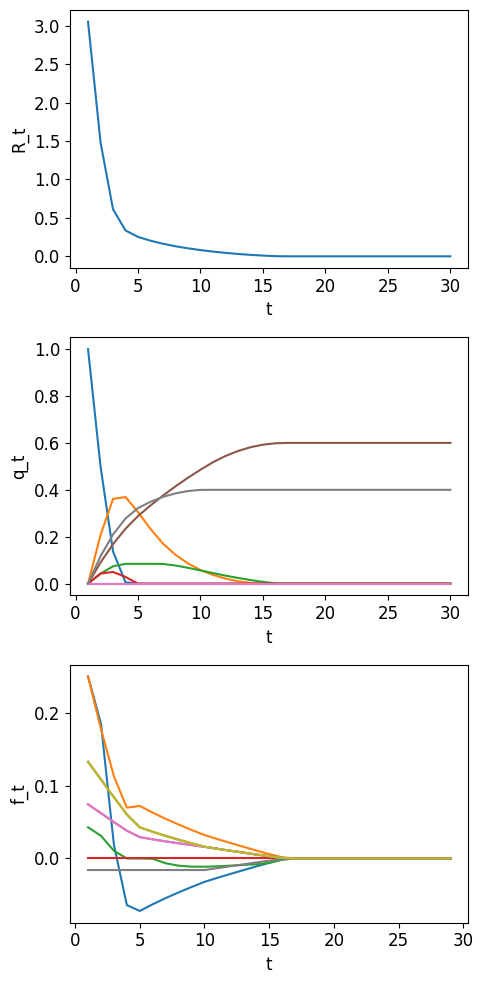

In [ ]:
# Import required library
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
import matplotlib
from opt_evac_data import *

# Initialize parameter
n,m = A.shape
f = cvx.Variable([m,T-1])
q = cvx.Variable([n,T])
node_risk = q.T @ r + cvx.square(q).T @ s
edge_risk = cvx.hstack([cvx.abs(f).T @ rtild + cvx.square(f).T @ stild, np.zeros(1)])
risk = node_risk + edge_risk

# Solve problem
constr = [q[:,0] == q1, q[:,1:] == A @ f + q[:,:-1], 0 <= q, q <= np.tile(Q,(T,1)).T, cvx.abs(f) <= np.tile(F,(T-1,1)).T]
p = cvx.Problem(cvx.Minimize(sum(risk)), constr)
p.solve(verbose=True, solver=cvx.ECOS)
arr = lambda _: np.array(_.value)
q, f, risk, node_risk = map(arr, (q, f, risk, node_risk))

# Print output
print("Total risk is ", p.value)
print("Evacuated at t =", (node_risk <= 1e-4).nonzero()[0][0] + 1)

# Plotting
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(3,1,figsize=(5,10))
axs[0].plot(np.arange(1,T+1), risk)
axs[0].set_ylabel("R_t")
axs[0].set_xlabel("t")
axs[1].plot(np.arange(1,T+1), q.T)
axs[1].set_ylabel("q_t")
axs[1].set_xlabel("t")
axs[2].plot(np.arange(1,T), f.T)
axs[2].set_ylabel("f_t")
axs[2].set_xlabel("t")
fig.tight_layout()
plt.show()

## <font color='yellow'>2. Optimal circuit design</font>

In [135]:
# Import required library
import numpy as np
import cvxpy as cvx
from blend_design_data import *

# Initialize variable
theta = cvx.Variable(k)

# Solve problem
objective = cvx.Minimize(0)
constraints = [np.log(P) @ theta <= np.log(P_spec)]
constraints += [np.log(D) @ theta <= np.log(D_spec)]
constraints += [np.log(A) @ theta <= np.log(A_spec)]
constraints += [cvx.sum(theta)==1, theta>=0]
cvx.Problem(objective,constraints).solve()

# now create design
w = np.exp(np.log(W) @ theta.value)
print("w = ", w)
print("theta = ", theta.value)



w =  [2.63859837 3.28069166 2.96934036 3.26617754 2.32426888 3.66532996
 2.92976112 3.68571815 3.8940303  3.3972013 ]
theta =  [0.01758686 0.49673786 0.00452331 0.47531367 0.00408995 0.00174836]


## <font color='yellow'>3. Filling the covariance matrix</font>

In [ ]:
# Import required library
import numpy as np
import cvxpy as cp

# Initialize variable
n1 = n2 = n3 = 1
n = n1 + n2 + n3
S = np.ones([n1+n2, n1+n2])
T = np.ones([n2+n3, n2+n3])
C_sim = np.matrix([[1,1,0],[1,1,1],[0,1,1]])

# Solve problem
C = cp.Variable((n,n), symmetric=True)
objective = cp.Minimize(cp.norm(C - C_sim, "fro")**2)
constraints = [C >> 0]
prob = cp.Problem(objective, constraints)
prob.solve()

# Print output
print("C = \n",C.value)
if all(np.linalg.eigvals(C_sim) >= 0):
    print("The matrix C_sim is positive semidefinite.")
else:
    print("The matrix C_sim is not positive semidefinite.")

if all(np.round(np.linalg.eigvals(C.value)) >= 0):
    print("The matrix recovered C is positive semidefinite.")
else:
    print("The matrix recovered C is not positive semidefinite.")


C = 
 [[1.10355273 0.8535544  0.1035527 ]
 [0.8535544  1.20710542 0.8535544 ]
 [0.1035527  0.8535544  1.10355273]]
The matrix C_sim is not positive semidefinite.
The matrix recovered C is positive semidefinite.


## <font color='yellow'>4. Control with various objectives</font>

<font color='yellow'>1. $\sum_{t=0}^{T-1} ||\textbf{u}_t||_2^2$</font>

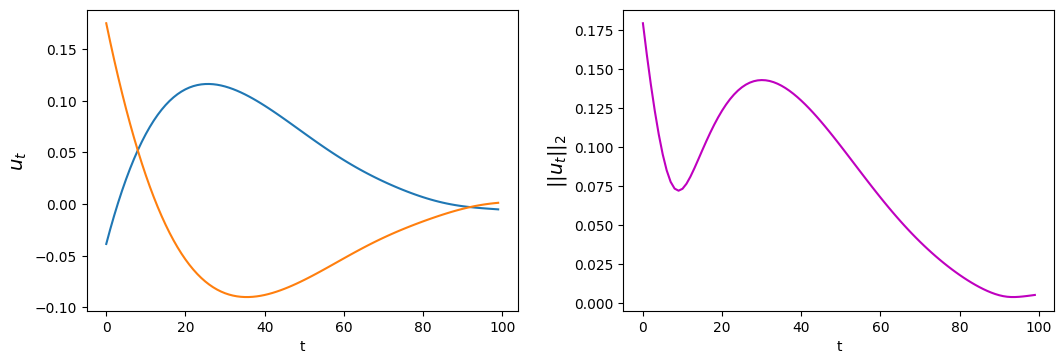

In [62]:
# Import required library
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from various_obj_regulator_data import *

# Initialize variable
x = cp.Variable((n,T+1))
u = cp.Variable((m,T))

# Solve problem
objective = cp.Minimize(cp.sum_squares(u))
const = [x[:,-1] == np.zeros(n)]
const.append(x[:,0] == x_init)
for t in range(1,T+1):
  const.append(x[:,t] == A @ x[:,t-1] + B @ u[:,t-1])
prob = cp.Problem(objective, const)
prob.solve()

# Plotting
fig = plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(u.value.T)
plt.ylabel("$u_t$", fontsize=14)
plt.xlabel("t")
plt.subplot(1,2,2)
plt.xlabel("t")
plt.plot(np.linalg.norm(u.value,axis=0),"m")
plt.ylabel("$||u_t||_2$", fontsize=14)
plt.tight_layout(pad = 2)

<font color='yellow'>2. $\sum_{t=0}^{T-1} ||\textbf{u}_t||_2$</font>

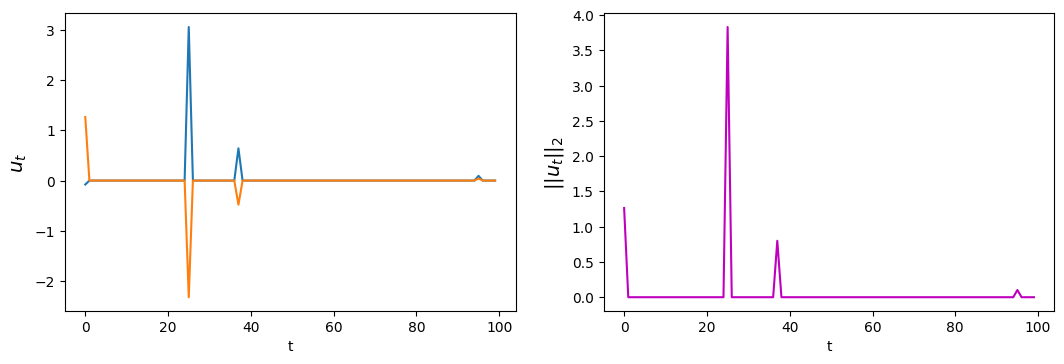

In [63]:
# Import required library
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from various_obj_regulator_data import *

# Initialize variable
x = cp.Variable((n,T+1))
u = cp.Variable((m,T))

# Solve problem
objective = cp.Minimize(cp.sum(cp.norm(u,2,axis=0)))
const = [x[:,-1] == np.zeros(n)]
const.append(x[:,0] == x_init)
for t in range(1,T+1):
  const.append(x[:,t] == A @ x[:,t-1] + B @ u[:,t-1])
prob = cp.Problem(objective, const)
prob.solve()

# Plotting
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(u.value.T)
plt.ylabel("$u_t$", fontsize=14)
plt.xlabel("t")
plt.subplot(1,2,2)
plt.xlabel("t")
plt.plot(np.linalg.norm(u.value,axis=0),"m")
plt.ylabel("$||u_t||_2$", fontsize=14)
plt.tight_layout(pad = 2)

<font color='yellow'>3. $max_{t=0,\dots,T-1} ||\textbf{u}_t||_2$</font>

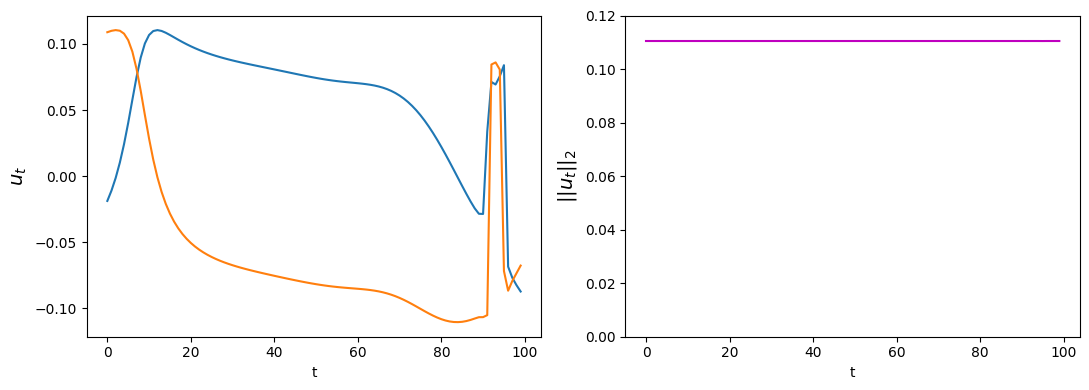

In [64]:
# Import required library
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from various_obj_regulator_data import *

# Initialize variable
x = cp.Variable((n,T+1))
u = cp.Variable((m,T))

# Solve problem
objective = cp.Minimize(cp.max(cp.norm(u,2,axis=0)))
const = [x[:,-1] == np.zeros(n)]
const.append(x[:,0] == x_init)
for t in range(1,T+1):
  const.append(x[:,t] == A @ x[:,t-1] + B @ u[:,t-1])
prob = cp.Problem(objective, const)
prob.solve()

# Plotting
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(u.value.T)
plt.ylabel("$u_t$", fontsize=14)
plt.xlabel("t")
plt.subplot(1,2,2)
plt.xlabel("t")
plt.plot(np.linalg.norm(u.value,axis=0),"m")
plt.ylabel("$||u_t||_2$", fontsize=14)
plt.ylim(ymin = 0, ymax = 0.12)
plt.tight_layout()

<font color='yellow'>4. $\sum_{t=0}^{T-1} ||\textbf{u}_t||_1$</font>

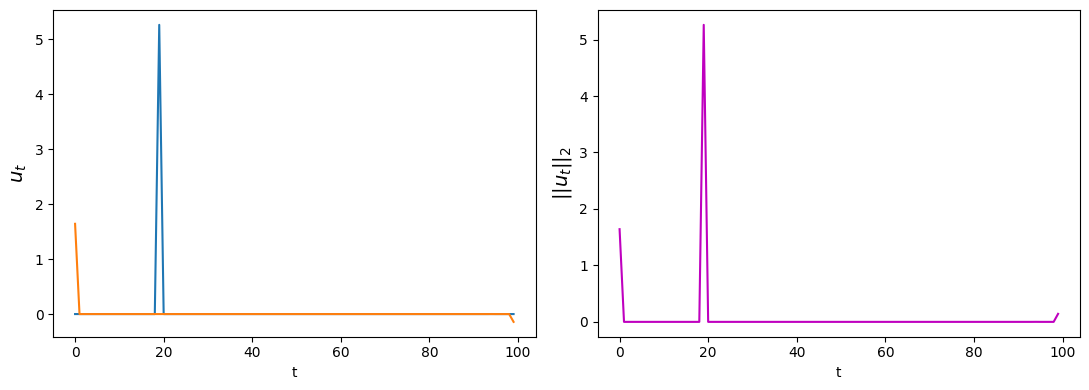

In [125]:
# Import required library
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from various_obj_regulator_data import *

# Initialize variable
x = cp.Variable((n,T+1))
u = cp.Variable((m,T))

# Solve problem
objective = cp.Minimize(cp.sum(cp.norm(u,1,axis=0)))
const = [x[:,-1] == np.zeros(n)]
const.append(x[:,0] == x_init)
for t in range(1,T+1):
  const.append(x[:,t] == A @ x[:,t-1] + B @ u[:,t-1])
prob = cp.Problem(objective, const)
prob.solve()

# Plotting
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(u.value.T)
plt.ylabel("$u_t$", fontsize=14)
plt.xlabel("t")
plt.subplot(1,2,2)
plt.xlabel("t")
plt.plot(np.linalg.norm(u.value,axis=0),"m")
plt.ylabel("$||u_t||_2$", fontsize=14)
plt.tight_layout()

## <font color='yellow'>5. Portfolio optimization</font>

In [123]:
# Import required library
import numpy as np
import cvxpy as cvx
from multi_risk_portfolio_data import *

# Initialize variable
w = cvx.Variable(n)
t = cvx.Variable()

# Solve problem
risks = [cvx.quad_form(w, Sigma) for Sigma in (Sigma_1, Sigma_2, Sigma_3, Sigma_4, Sigma_5, Sigma_6)]
risk_constraints = [risk <= t for risk in risks]
prob = cvx.Problem(cvx.Maximize(w.T @ mu - gamma * t), risk_constraints + [cvx.sum(w) == 1])
prob.solve()

# Print output
print("weights:")
print("\n".join(["{}".format(weight) for weight in w.value]))
print("worst case : ", t.value)
print("risk values:")
print("\n".join(["{}".format(risk.value) for risk in risks]))
print("gamma_k values:")
print("\n".join(["{}".format(risk.dual_value) for risk in risk_constraints]))

weights:
0.4247382049873743
0.6642699652212044
-0.11469037220485757
1.3805550930331925
1.4242285197751403
-1.527064897348089
-0.6140154499013144
-0.4987908148392034
-0.25406875723047384
0.11483850850702625
worst case :  0.12188147875724109
risk values:
0.12188147878073646
0.0845435093507211
0.08247154824172492
0.12188147874793029
0.12188147884781253
0.12188147867241997
gamma_k values:
[0.29231555]
[3.35675336e-10]
[3.53686168e-10]
[0.46580236]
[0.14230459]
[0.0995775]
